In [99]:
import rosbag
import numpy as np
import sys
import csi_utils.constants as constants
import csi_utils.transform_utils as transform_utils
import csi_utils.pipeline_utils as pipeline_utils
import csi_utils.comp_utils as comp_utils
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.cm import ScalarMappable
import mne

In [100]:
# Define variables to store your data
comp = np.load("192.168.43.1-157.npy")
apply_nts = True
idx = 0
valid_tx_ant = [0,1,2,3]
# mne.beamformer.rap_music()

In [101]:
def draw_channel_image_4x4(channel_1, channel_2):
    print("afad")
    num_tx_slots = channel_1.shape[2]
    num_rx_slots = channel_1.shape[1]
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    fig, axs = plt.subplots(num_tx_slots*2, num_rx_slots, figsize=(24, 24),
                            gridspec_kw={'height_ratios': [1, 0.7] * num_tx_slots})
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    amplitude_1 = (np.abs(channel_1))
    amplitude_2 = (np.abs(channel_2))
    min_amp = min(np.min(amplitude_1), np.min(amplitude_2))
    max_amp = max(np.max(amplitude_1), np.max(amplitude_2))
    phase_1 = np.unwrap(np.angle(channel_1))
    phase_2 = np.unwrap(np.angle(channel_2))
    min_phase = min(np.min(phase_1), np.min(phase_2))
    max_phase = max(np.max(phase_1), np.max(phase_2))
    print(min_phase, max_phase)
    for i in range(0, num_tx_slots*2, 2):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0, f"Tx Ant {i//2}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude (dB)")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            # axs[i, j].plot(20*np.log10(np.abs(channel_1[:, j, i//2])),
            #                label="LOS")
            axs[i, j].plot((np.abs(channel_1[:, j, i//2])),
                           label="LOS")
            # axs[i, j].plot(20*np.log10(np.abs(channel_2[:, j, i//2])),
                        #    label="NLOS")
            axs[i, j].legend()
            # plot phase
            axs[i+1, j].set_xlabel("Subcarrier indices")
            axs[i+1, j].set_ylabel("Phase (deg)")
            axs[i+1, j].set_ylim(min_phase, max_phase)
            axs[i+1, j].set_yticks(y_tick_positions)
            axs[i+1, j].set_yticklabels(y_tick_labels)
            # don't wrap 
            # axs[i+1, j].plot(np.angle(channel_1[:, j, i//2]),
            #                  label="LOS")
            # axs[i+1, j].plot(np.angle(channel_2[:, j, i//2]),
            #                  label="NLOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_1[:, j, i//2])),
                             label="LOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_2[:, j, i//2])),
                             label="NLOS2")
            axs[i+1, j].legend() 
    fig.set_tight_layout(True)   
    plt.savefig('40 157 los vs nlos.png')
    plt.show()
   

def draw_amplitude_4x4(channel, figure_title=""):
    print("afad")
    num_tx_slots = channel.shape[2]
    num_rx_slots = channel.shape[1]
    fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    amplitude = (np.abs(channel))
    min_amp = np.min(amplitude)
    max_amp = np.max(amplitude)
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            axs[i, j].plot((np.abs(channel[:, j, i])),
                           label="LOS")
            axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    plt.show()

In [102]:
def draw_amplitudes_4x4(bag, figure_title="", average=False, fig=None, axs=None, show=True, min_a=None, max_a=None):
    print("afad")
    num_tx_slots = 4
    num_rx_slots = 4
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    if (fig is None):
        fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
        fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    # amplitude = (np.abs(channel))
    min_amp = 1000
    max_amp = -1000
    # phase = np.unwrap(np.angle(channel))
    # min_phase = np.min(phase)
    # max_phase = np.max(phase)
    
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
                if i == 0:
                    # Place Rx antenna labels at the top
                    axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
                if j == 0:
                # Place Tx antenna labels on the left 
                    axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                k = 20
                if not average:
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        amplitude = (np.abs(channel))
                        min_amp = min(np.min(amplitude), min_amp)
                        max_amp = max(np.max(amplitude), max_amp)
                        # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                        axs[i, j].plot((amplitude[:, j, i]), label="l")
                        k += 1
                        if k == 30:
                            break
                else:
                    totalValues = None
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        if totalValues is None:
                            totalValues = channel
                        else:
                            totalValues += channel
                        k += 1
                        if k == 30:
                            break
                    amplitude = (np.abs(totalValues))
                    min_amp = min(np.min(amplitude), min_amp)
                    max_amp = max(np.max(amplitude), max_amp)
                    # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                    axs[i, j].plot((amplitude[:, j, i]), label="l")
                     

                    
                # plot magnitude
                axs[i, j].set_xlabel("Subcarrier indices")
                axs[i, j].set_ylabel("Magnitude")
                if (min_a != None):
                     min_amp = min_a
                if (max_a != None):
                     max_amp = max_a
                mi, ma = axs[i, j].get_ylim()
                axs[i, j].set_ylim(min(mi,min_amp-10), max(ma, max_amp+10))

                # axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    if show:
        plt.show()

In [103]:
def compare_amplitudes_4x4(bags, figure_title=""):
    fig, axs = plt.subplots(4, 4, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    for bag in bags:
        print("drawing bag")
        draw_amplitudes_4x4(bag, "", True, fig, axs, False)
    for i in range(4):
        for j in range(4):
            axs[i, j].legend([f"Location {k}" for k in range(1, 6)])
    plt.show()

In [104]:
# headon = rosbag.Bag("../HeadOn.bag")
# ninetydeg = rosbag.Bag("../90deg2.bag")
# fortyfive = rosbag.Bag("../45deg.bag")
# nfortyfive = rosbag.Bag("../n45deg.bag")
import tqdm
#smooth over last n packets according to algo
smoothing_window = 1
#aoa search space
theta_space = np.linspace(-np.pi/2,np.pi/2,360)
#tof search space
tof_space = np.linspace(-40,40,240)

#antenna position (interleaved x-y), see antennas.md
rx_pos = np.asarray([0,  0,
    0,  -0.06,
    0,  -0.03,
    0,  -0.09]).reshape((-1,2))
channels = {}
times = {}
aoas = {}
rssis = {}
profs = {}
aoa_sensors = {}


In [127]:
def get_angle_profiles(bag, algorithm, subcarriers = range(0, 50)):
  """Returns a list of [(time, [angles], [profile])] for each packet

  Arguments:
  - bag: The bag with csi data to get the angle profiles from
  - algorithm: The algorithm to use to get the angle likelihood ("music", "aoa", "fft")
  - subcarriers: The subcarriers to use for the algorithm. Should be a subset of the integers from 0 to 49
  """
  print("ALGORITHM:", algorithm)
  num = 0
  data = []
  aoa_sensor = None
  if algorithm == "music":
    aoa_sensor = transform_utils.music_aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
    aoa_sensor.prof_dim = 4
  elif algorithm == "aoa":
    aoa_sensor = transform_utils.aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
  elif algorithm == "fft":
    aoa_sensor = transform_utils.fft_aoa_sensor(rx_pos, theta_space, smoothing_window)
  elif algorithm == "othermusic":
    tofs = np.linspace(-40, 40, 180)
    aoa_sensor = transform_utils.full_music_aoa_sensor(rx_pos, theta_space, tofs, smoothing_window)
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      if num == 1:
        print(csi.shape)
      #assuming this does not change
      if algorithm == "othermusic":
        res = aoa_sensor(csi, (msg.chan, msg.bw*1e6))
        print("Channel:", msg.chan, " BW:", msg.bw*1e6)
      else:
        res = aoa_sensor.run(csi,(msg.chan,msg.bw*1e6), subcarriers=subcarriers)
      num += 1
      data.append((t.to_sec(), theta_space * 180 / np.pi, res[1]))
  print("Packets:", num)
  return data

def plot_angle_profiles(data, title, savename=None):
  """Plots a list of [(time, [angles], [profile])]"""
  fig, ax = plt.subplots()
  plt.title(title)
  plt.ylabel("Angle (degrees)")
  plt.xlabel("Time")
  for time, angles, profile in data:
    ax.scatter([time] * len(angles), angles, c=profile, s=10)
  if savename is not None:
    plt.savefig(savename)
  plt.show()

ALGORITHM: music


311it [00:00, 3307.70it/s]


(50, 4, 4)
Packets: 311
ALGORITHM: music


311it [00:00, 3188.86it/s]


(50, 4, 4)
Packets: 311
ALGORITHM: music


0it [00:00, ?it/s]

(50, 4, 4)


231it [00:00, 2922.68it/s]


Packets: 231
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


231it [00:00, 2859.01it/s]


Packets: 231
ALGORITHM: music


0it [00:00, ?it/s]

(50, 4, 4)


408it [00:00, 3128.84it/s]


Packets: 408
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


408it [00:00, 3104.01it/s]


Packets: 408
ALGORITHM: othermusic


0it [00:00, ?it/s]

Channel: 157  BW: 20000000.0
(50, 4, 4)


2it [00:00, 15.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


4it [00:00, 14.26it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


6it [00:00, 14.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


8it [00:00, 14.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


10it [00:00, 13.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


12it [00:00, 13.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


14it [00:00, 14.14it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


16it [00:01, 14.34it/s]

Channel: 157  BW: 20000000.0


20it [00:01, 14.55it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


24it [00:01, 15.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


28it [00:01, 15.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


32it [00:02, 15.65it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


36it [00:02, 15.81it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


38it [00:02, 15.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


42it [00:02, 15.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


46it [00:03, 15.09it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


50it [00:03, 15.69it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


54it [00:03, 16.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


58it [00:03, 15.14it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


62it [00:04, 15.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


66it [00:04, 16.02it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


70it [00:04, 15.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


74it [00:04, 15.39it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


78it [00:05, 15.66it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


82it [00:05, 15.53it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


86it [00:05, 15.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


90it [00:05, 16.95it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


94it [00:06, 16.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


98it [00:06, 16.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


100it [00:06, 16.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


104it [00:06, 16.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


108it [00:06, 15.23it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


112it [00:07, 16.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


116it [00:07, 15.74it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


120it [00:07, 15.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


124it [00:07, 16.05it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


128it [00:08, 14.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


132it [00:08, 14.62it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


136it [00:08, 15.36it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


140it [00:09, 15.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


144it [00:09, 15.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


148it [00:09, 15.66it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


150it [00:09, 15.51it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


154it [00:09, 14.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


158it [00:10, 14.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


162it [00:10, 15.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


166it [00:10, 15.55it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


170it [00:11, 15.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


172it [00:11, 15.53it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


176it [00:11, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


180it [00:11, 13.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


184it [00:11, 14.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


188it [00:12, 15.12it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


190it [00:12, 15.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


194it [00:12, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


198it [00:12, 14.75it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


202it [00:13, 14.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


204it [00:13, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


208it [00:13, 15.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


212it [00:13, 14.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


214it [00:14, 14.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


218it [00:14, 14.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


220it [00:14, 14.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


224it [00:14, 14.95it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


228it [00:14, 14.51it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


230it [00:15, 14.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


234it [00:15, 14.79it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


236it [00:15, 14.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


240it [00:15, 13.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


244it [00:16, 14.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


248it [00:16, 14.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


252it [00:16, 14.86it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


256it [00:16, 15.15it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


258it [00:17, 14.33it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


262it [00:17, 15.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


266it [00:17, 14.92it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


268it [00:17, 15.27it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


272it [00:17, 14.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


276it [00:18, 15.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


280it [00:18, 15.85it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


284it [00:18, 15.12it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


288it [00:19, 15.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


292it [00:19, 14.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


294it [00:19, 14.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


298it [00:19, 14.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


300it [00:19, 14.62it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


304it [00:20, 14.82it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


308it [00:20, 15.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


312it [00:20, 15.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


316it [00:20, 14.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


318it [00:21, 14.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


322it [00:21, 14.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


326it [00:21, 14.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


330it [00:21, 14.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


334it [00:22, 15.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


338it [00:22, 15.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


340it [00:22, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


344it [00:22, 14.70it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


346it [00:22, 14.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


350it [00:23, 15.12it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


354it [00:23, 15.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


358it [00:23, 15.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


362it [00:23, 15.48it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


366it [00:24, 15.57it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


368it [00:24, 14.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


372it [00:24, 15.50it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


376it [00:24, 15.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


380it [00:25, 15.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


382it [00:25, 14.53it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


386it [00:25, 14.62it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


390it [00:25, 14.49it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


392it [00:26, 13.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


396it [00:26, 14.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


398it [00:26, 14.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


402it [00:26, 14.38it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


406it [00:26, 15.11it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


408it [00:27, 15.06it/s]


Channel: 157  BW: 20000000.0
Packets: 408
ALGORITHM: music


416it [00:00, 3082.33it/s]


(50, 4, 4)
Packets: 416
ALGORITHM: aoa


0it [00:00, ?it/s]

(50, 4, 4)


416it [00:00, 2968.12it/s]


Packets: 416
ALGORITHM: othermusic


0it [00:00, ?it/s]

Channel: 157  BW: 20000000.0
(50, 4, 4)


2it [00:00, 16.51it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


4it [00:00, 16.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


6it [00:00, 16.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


8it [00:00, 15.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


10it [00:00, 16.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


12it [00:00, 16.18it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


14it [00:00, 16.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


16it [00:00, 16.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


18it [00:01, 16.79it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


20it [00:01, 15.99it/s]

Channel: 157  BW: 20000000.0


22it [00:01, 16.03it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


24it [00:01, 16.36it/s]

Channel: 157  BW: 20000000.0


26it [00:01, 16.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


28it [00:01, 16.81it/s]

Channel: 157  BW: 20000000.0


30it [00:01, 15.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


34it [00:02, 16.07it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


36it [00:02, 16.42it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


38it [00:02, 16.92it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


40it [00:02, 16.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


42it [00:02, 16.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


44it [00:02, 16.55it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


46it [00:02, 17.00it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


48it [00:02, 16.20it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


50it [00:03, 16.07it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


52it [00:03, 15.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


54it [00:03, 15.99it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


56it [00:03, 15.77it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


58it [00:03, 16.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


60it [00:03, 15.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


62it [00:03, 15.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


66it [00:04, 15.98it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


70it [00:04, 16.45it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


74it [00:04, 16.17it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


78it [00:04, 15.90it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


82it [00:05, 15.92it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


84it [00:05, 13.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


86it [00:05, 14.30it/s]

Channel: 157  BW: 20000000.0


88it [00:05, 14.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


90it [00:05, 13.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


92it [00:05, 13.68it/s]

Channel: 157  BW: 20000000.0


94it [00:05, 13.97it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


96it [00:06, 14.23it/s]

Channel: 157  BW: 20000000.0


98it [00:06, 14.73it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


102it [00:06, 15.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


106it [00:06, 14.94it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


110it [00:07, 15.02it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


112it [00:07, 15.44it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


116it [00:07, 15.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


120it [00:07, 15.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


124it [00:07, 15.07it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


126it [00:08, 14.68it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


130it [00:08, 14.64it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


132it [00:08, 14.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


136it [00:08, 14.06it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


140it [00:09, 15.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


144it [00:09, 15.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


148it [00:09, 15.62it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


152it [00:09, 15.81it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


156it [00:10, 15.61it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


160it [00:10, 15.58it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


164it [00:10, 15.44it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


168it [00:10, 14.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


172it [00:11, 14.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


174it [00:11, 14.35it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


178it [00:11, 14.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


182it [00:11, 15.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


186it [00:12, 15.64it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


188it [00:12, 15.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


192it [00:12, 14.31it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


194it [00:12, 14.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


198it [00:12, 14.46it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


200it [00:13, 14.35it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


204it [00:13, 14.98it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


208it [00:13, 14.77it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


212it [00:13, 14.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


214it [00:14, 13.81it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


218it [00:14, 14.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


222it [00:14, 14.22it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


224it [00:14, 14.57it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


228it [00:14, 14.52it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


232it [00:15, 13.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


234it [00:15, 13.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


238it [00:15, 13.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


240it [00:15, 12.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


244it [00:16, 14.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


248it [00:16, 14.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


250it [00:16, 14.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


254it [00:16, 14.29it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


258it [00:17, 14.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


262it [00:17, 14.98it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


266it [00:17, 15.25it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


268it [00:17, 15.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


272it [00:18, 14.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


276it [00:18, 14.72it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


280it [00:18, 15.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


282it [00:18, 14.21it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


286it [00:19, 14.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


290it [00:19, 15.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


294it [00:19, 15.51it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


296it [00:19, 14.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


300it [00:19, 14.56it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


302it [00:20, 13.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


306it [00:20, 13.89it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


308it [00:20, 13.93it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


312it [00:20, 13.43it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


316it [00:21, 14.16it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


320it [00:21, 15.01it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


324it [00:21, 15.37it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


328it [00:21, 15.24it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


332it [00:22, 15.43it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


334it [00:22, 15.19it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


338it [00:22, 13.71it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


340it [00:22, 13.25it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


344it [00:23, 12.60it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


348it [00:23, 13.81it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


350it [00:23, 13.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


354it [00:23, 15.13it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


358it [00:24, 13.91it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


362it [00:24, 14.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


364it [00:24, 14.65it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


368it [00:24, 12.84it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


370it [00:25, 11.78it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


374it [00:25, 12.59it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


378it [00:25, 13.47it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


380it [00:25, 13.87it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


384it [00:26, 13.64it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


386it [00:26, 13.67it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


390it [00:26, 13.63it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


392it [00:26, 13.96it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


396it [00:26, 13.32it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


398it [00:27, 13.68it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


402it [00:27, 13.83it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


404it [00:27, 14.08it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


408it [00:27, 13.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


410it [00:27, 12.80it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


414it [00:28, 13.76it/s]

Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0
Channel: 157  BW: 20000000.0


416it [00:28, 14.66it/s]


Channel: 157  BW: 20000000.0
Packets: 416


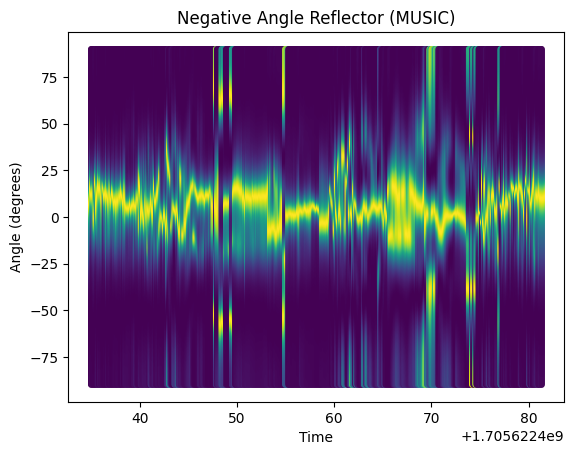

In [129]:
rotationData = rosbag.Bag("rotationData.bag")
controlData = rosbag.Bag("testingData/control.bag")
musicData1 = get_angle_profiles(rotationData, "music", [0, 10, 20, 30, 40, 49])
musicData2 = get_angle_profiles(rotationData, "music")

controlAnglesMusic = get_angle_profiles(controlData, "music")
controlAnglesAOA = get_angle_profiles(controlData, "aoa")

neg45Data = rosbag.Bag("testingData/reflector1.bag")
neg45AnglesMusic = get_angle_profiles(neg45Data, "music")
neg45AnglesAOA = get_angle_profiles(neg45Data, "aoa")
neg45AnglesOtherMusic = get_angle_profiles(neg45Data, "othermusic")


pos45Data = rosbag.Bag("testingData/reflector3.bag")
pos45AnglesMusic = get_angle_profiles(pos45Data, "music")
pos45AnglesAOA = get_angle_profiles(pos45Data, "aoa")
pos45AnglesOtherMusic = get_angle_profiles(pos45Data, "othermusic")
# aoaData = get_angle_profiles(rotationData, "aoa")
# clippedMusic = []
# for i in range(len(musicData)):
#   row = musicData[i][2].copy()
#   row[row < 1] = 0
#   clippedMusic.append((musicData[i][0], musicData[i][1], row))
# clippedAoa = []
# for i in range(len(aoaData)):
#   row = aoaData[i][2].copy()
#   row[row < 1] = 0
#   clippedAoa.append((aoaData[i][0], aoaData[i][1], row))
# clippedCombined = []
# for i in range(len(musicData)):
#   clippedCombined.append((musicData[i][0], musicData[i][1], clippedMusic[i][2] * clippedMusic[i][2]))

# differences = []
# for i in range(len(musicData)):
#   differences.append((musicData[i][0], musicData[i][1], np.isclose(musicData[i][2], aoaData[i][2], rtol=0.3)))

# print(neg45AnglesMusic)

# plot_angle_profiles(neg45AnglesAOA, "Negative Angle Reflector (AOA)")
plot_angle_profiles(neg45AnglesMusic, "Negative Angle Reflector (MUSIC)")
# plot_angle_profiles(neg45AnglesOtherMusic, "Negative Angle Reflector (Other MUSIC)")

In [98]:
controlAnglesOtherMusic = get_angle_profiles(controlData, "othermusic")

ALGORITHM: othermusic


5it [00:00, 42.71it/s]

(50, 4, 4)


231it [00:08, 28.43it/s]

Packets: 231


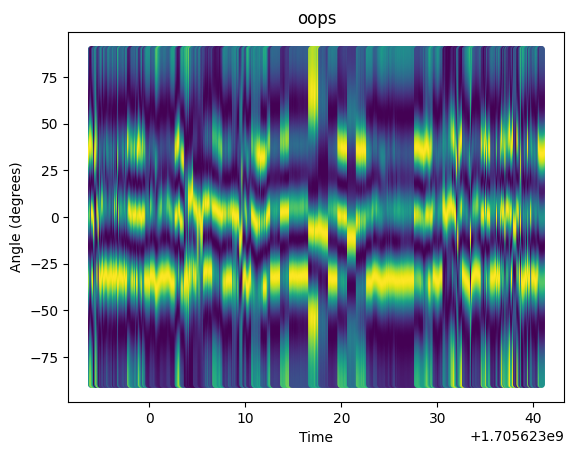

In [131]:

# plot_angle_profiles(neg45AnglesMusic, "Positive Angle Reflector (MUSIC)")
# print("HEYYYY")
fig, ax = plt.subplots()
plt.title("oops")
plt.ylabel("Angle (degrees)")
plt.xlabel("Time")
for time, angles, profile in pos45AnglesOtherMusic:
  # print(len(angles), len(profile))
  # print(np.max(profile))
  # print(type(profile))
  # idx = np.argmax(profile)
  newprofile = []
  for i in range(360):
    # print(profile[i])
    newprofile.append(profile[i][0])
    # newprofile.append(np.average(profile[i][0:8]))
  newprofile = np.array(newprofile)
  # print(np.shape(profile))
  # print(idx)
  # ax.scatter(time, angles[idx], s=10)
  ax.scatter([time] * len(angles), angles, c=newprofile * 10, s=10)

In [ ]:
# print("HEYYYY")
fig, ax = plt.subplots()
plt.title("oops")
plt.ylabel("Angle (degrees)")
plt.xlabel("Time")
for time, angles, profile in neg45AnglesOtherMusic:
  # print(len(angles), len(profile))
  # print(np.max(profile))
  # print(type(profile))
  # idx = np.argmax(profile)
  newprofile = []
  for i in range(360):
    # print(profile[i])
    # newprofile.append(np.average(profile[i]))
    newprofile.append(np.average(profile[i][40:49]))
  newprofile = np.array(newprofile)
  print(np.shape(profile))
  # print(idx)
  # ax.scatter(time, angles[idx], s=10)
  ax.scatter([time] * len(angles), angles, c=newprofile * 10, s=10)

time_visualizeprofile(rotationData, "Rotation Data Over Time (1d AOA)", "aoa")

ALGORITHM: aoa


311it [00:00, 1805.03it/s]

(50, 4, 4)
Packets: 311


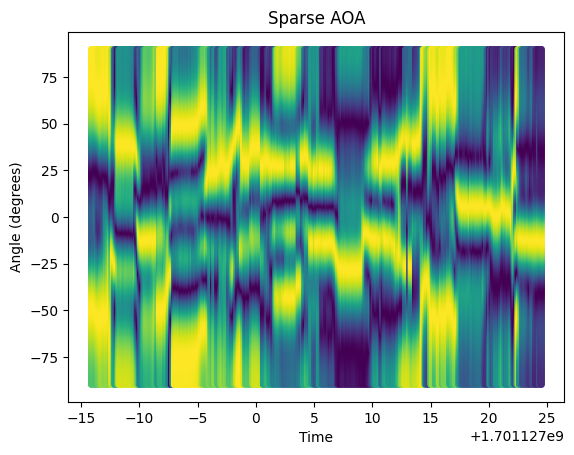

In [10]:
plot_angle_profiles(get_angle_profiles(rotationData, "aoa", range(0, 10)), f"Sparse AOA")

In [10]:
# Load the ROS bag file
# bag_1 = rosbag.Bag("../2023-11-10-15-38-09.bag")
# no_antennae = rosbag.Bag("../los_no_r_antennae_no_t_antennae.bag")
# no_rx_antennae = rosbag.Bag("../los_no_rx_antennae.bag")
# no_rx_antennae_2 = rosbag.Bag("../los_no_rx_2.bag")
# both_antennae_low = rosbag.Bag("../los_lowpower.bag")
# both_antennae = rosbag.Bag("../los_both_antennae.bag")
# los_nonatt = rosbag.Bag("../los_nonattenuated.bag")
# los_att = rosbag.Bag("../los_attenuated.bag")
# los_no_blocker = rosbag.Bag("../los_no_signal_blocker.bag")
# los_blocker = rosbag.Bag("../los_signal_blocker.bag")
foil = rosbag.Bag("../foil.bag")
foil2 = rosbag.Bag("../foil2.bag")
nofoil = rosbag.Bag("../nofoil.bag")
onefoil = rosbag.Bag("../one_foil.bag")
onefoil2 = rosbag.Bag("../one_foil2.bag")
test = rosbag.Bag("../test.bag")
test2 = rosbag.Bag("../test2.bag")
test3 = rosbag.Bag("../test3.bag")
calibration_data = rosbag.Bag("../new_calibration_data.bag")
headon = rosbag.Bag("../HeadOn.bag")
ninetydeg = rosbag.Bag("../90degrees.bag")
nlosbags = []
for k in range(1, 6):
    filename = f"../nlos_{k}.bag"
    nlosbags.append(rosbag.Bag(filename))
# bag_2 = rosbag.Bag('/home/sora/wifi_ws/rosbag_res/20 11 nlos.bag')

FileNotFoundError: [Errno 2] No such file or directory: '../foil.bag'

In [ ]:
# no_antennae_channel = pipeline_utils.extract_csi(next(no_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# no_rx_antennae_channel = pipeline_utils.extract_csi(next(no_rx_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# both_antennae_channel = pipeline_utils.extract_csi(next(both_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# i = 0
# for ((_, na, _), (_, nra, _), (_, ba, _)) in zip(no_antennae, no_rx_antennae, both_antennae):
#     draw_amplitude_4x4(pipeline_utils.extract_csi(na, None, apply_nts, valid_tx_ant), "3.76m LOS, No Antennae")
#     draw_amplitude_4x4(pipeline_utils.extract_csi(nra, None, apply_nts, valid_tx_ant), "3.76 LOS, No Rx Antennae")
#     draw_amplitude_4x4(pipeline_utils.extract_csi(ba, None, apply_nts, valid_tx_ant), "3.76 LOS, All Antennae")
#     i += 1
#     if (i == 10):
        # break
print(type(onefoil))
print(type(nofoil))
compare_amplitudes_4x4([test, test2, test3])
# draw_amplitudes_4x4(test)
# compare_amplitudes_4x4(nlosbags, "4.88m nlos")
# draw_amplitudes_4x4(nofoil, "4.88m No Foil", True)
# draw_amplitudes_4x4(onefoil2, "4.88m OneFoil")
# draw_amplitudes_4x4(foil, "4.88m Foil")
# draw_amplitudes_4x4(foil, "4.88m Foil2")


# draw_amplitudes_4x4(both_antennae, "3.76m LOS, Both Antennae")
# draw_amplitudes_4x4(both_antennae_low, "4.88m LOS low power, Both Antennae")
# draw_amplitudes_4x4(no_rx_antennae, "3.76m LOS, No Rx Antennae")
# draw_amplitudes_4x4(no_rx_antennae_2, "3.76m LOS, No Rx Antennae 3")
# draw_amplitudes_4x4(no_antennae, "3.76m LOS, No Antennae")
# draw_amplitude_4x4(no_antennae_channel, "3.76m LOS, No Antennae")
# draw_amplitude_4x4(no_rx_antennae_channel, "3.76 LOS, No Rx Antennae")
# draw_amplitude_4x4(no_rx_antennae_channel, "3.76 LOS, All Antennae")

In [ ]:
bearings = rosbag.Bag("../bearingTest5.bag")

def get_aoa(data, degrees=True):
    if degrees:
        return 180/np.pi * data[1].aoa[0]
    return data[1].aoa[0]

def graph_aoa(bag):
    times = []
    angles = []
    for data in bag:
        angles.append(get_aoa(data))
        times.append(data[1].header.stamp.secs + 0.000000001 * data[1].header.stamp.nsecs - bag.get_start_time())
    plt.scatter(times, angles, s=7)
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.show()
# print(bearings.get_start_time())
# for data in bearings:
#     # pass
#     # print(data)
#     # print(get_aoa(data))
#     print(data)
#     # print(data[1].header.stamp.secs)
#     # channel = pipeline_utils(data[1], None, False, valid_tx_ant)
#     # amplitude = (np.abs(channel))
graph_aoa(bearings)

In [ ]:
def graph_angle(bagfile):
    return